In [1]:
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "position", "embed", "number", "comparison"],
    "Garden-Path Effects": ["gardenpath", "npz"],
    "Gross Syntactic State": ["subordination"],
    "Center Embedding": ["center"],
    "Transformations": ["passive", "cleft"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
os.chdir("..")
ppl_data_path = Path("data/raw/perplexity.csv")
test_suite_results_path = Path("data/raw/test_suite_results.csv")

In [9]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
results_df = pd.read_csv(test_suite_results_path)

# Split model_id into constituent parts
model_ids = results_df.model_id.str.split("_", expand=True).rename(columns={0: "model", 1: "corpus", 2: "seed"})
results_df = results_df.join(model_ids).drop(columns=["model_id"])
results_df["seed"] = results_df.seed.astype(int)

# Add tags
results_df["tag"] = results_df.test_suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)

In [10]:
results_df.head()

,test_suite,item_number,correct,model,corpus,seed,tag,circuit
0,fgd,1,True,vanilla,ptb,111,fgd,Long-Distance Dependencies


### Checks

In [12]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    raise ValueError("Each model--corpus--seed must have perplexity data.")

## Main analyses

1. barplot ranking model accuracies
2. scatter plot with ppl on x-axis and SG score on y-axis (for a given dataset size -- or maybe all of them together?)
3. variance in ppl vs variance in SG score for a single model across seeds and/or sizes

Test suite analyses

1. within-tag/circuit ppl-SG correlations
2. circuit-circuit coordination heatmap
3. robustness to stability modification}

### Global settings

e.g. to maintain consistent hues across model graphs, etc.

In [20]:
model_order = sorted(set(results_df.model))
corpus_order = sorted(set(results_df.corpus))
circuit_order = sorted(set(results_df.circuit))

### Data prep

In [24]:
# Join PPL and accuracy data.
joined_data = results_df.groupby(["model", "corpus", "seed"]).correct.agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model,corpus,seed,correct,test_loss,test_ppl
0,vanilla,ptb,111,True,4.385945,80.314114


In [56]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = results_df.groupby(["model", "corpus", "seed", "circuit"]).correct.agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model,corpus,seed,circuit,correct,test_loss,test_ppl
0,vanilla,ptb,111,Long-Distance Dependencies,True,4.385945,80.314114


In [57]:
# Analyze stability to modification.
def has_modifier(ts):
    if "no-modifier" in ts:
        return False
    elif "modifier" in ts:
        return True
    else:
        return None
results_df["has_modifier"] = results_df.test_suite.transform(has_modifier)

# Store subset of test suites which have definite modifier/no-modifier marking
results_df_mod = results_df[~(results_df.has_modifier.isna())]
# Get base test suite (without modifier/no-modifier marking)
results_df_mod["test_suite_base"] = results_df_mod.test_suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
results_df_mod.head()

,test_suite,item_number,correct,model,corpus,seed,tag,circuit,has_modifier,test_suite_base


### Accuracy across models

Text(0,0.5,'Accuracy')

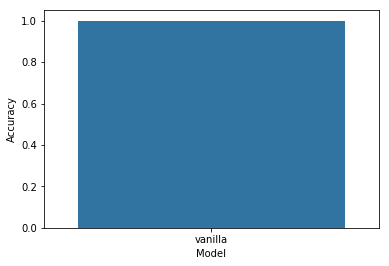

In [14]:
sns.barplot(data=results_df.reset_index(), x="model", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

### Accuracy vs perplexity

In [17]:
corpus_to_size = {
    "ptb": 2,
    "ptb-nanc-med": 4,
    "ptb-nanc-big": 6,
}

model_colors = dict(zip(model_order,
                        ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))

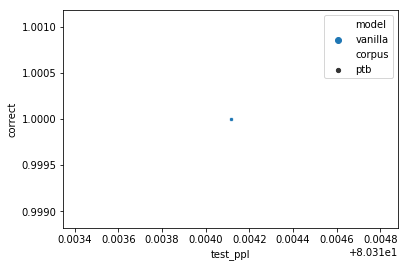

In [22]:
f, ax = plt.subplots()
# sns.regplot(data=graph_data, x="test_ppl", y="correct",
#             scatter_kws={"s": graph_data["corpus"].map(corpus_to_size),
#                          "facecolors": graph_data.model.map(model_colors)})
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="model", size="corpus",
                hue_order=model_order, size_order=corpus_order)

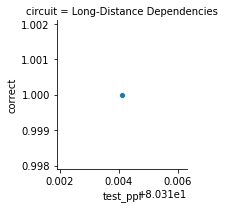

In [52]:
g = sns.FacetGrid(data=joined_data_circuits, col="circuit")
g.map(sns.scatterplot, "test_ppl", "correct", "model",
      hue_order=model_order)

### Variance in accuracy vs variance in perplexity

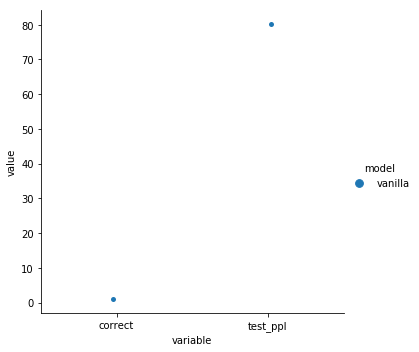

In [39]:
catplot_ticks = ["correct", "test_ppl"]
catplot_data = joined_data.melt(id_vars=set(joined_data.columns) - set(catplot_ticks))

g = sns.catplot(data=catplot_data,
                x="variable", y="value", hue="model")

### Circuit–circuit correlations

TypeError: zip argument #2 must support iteration

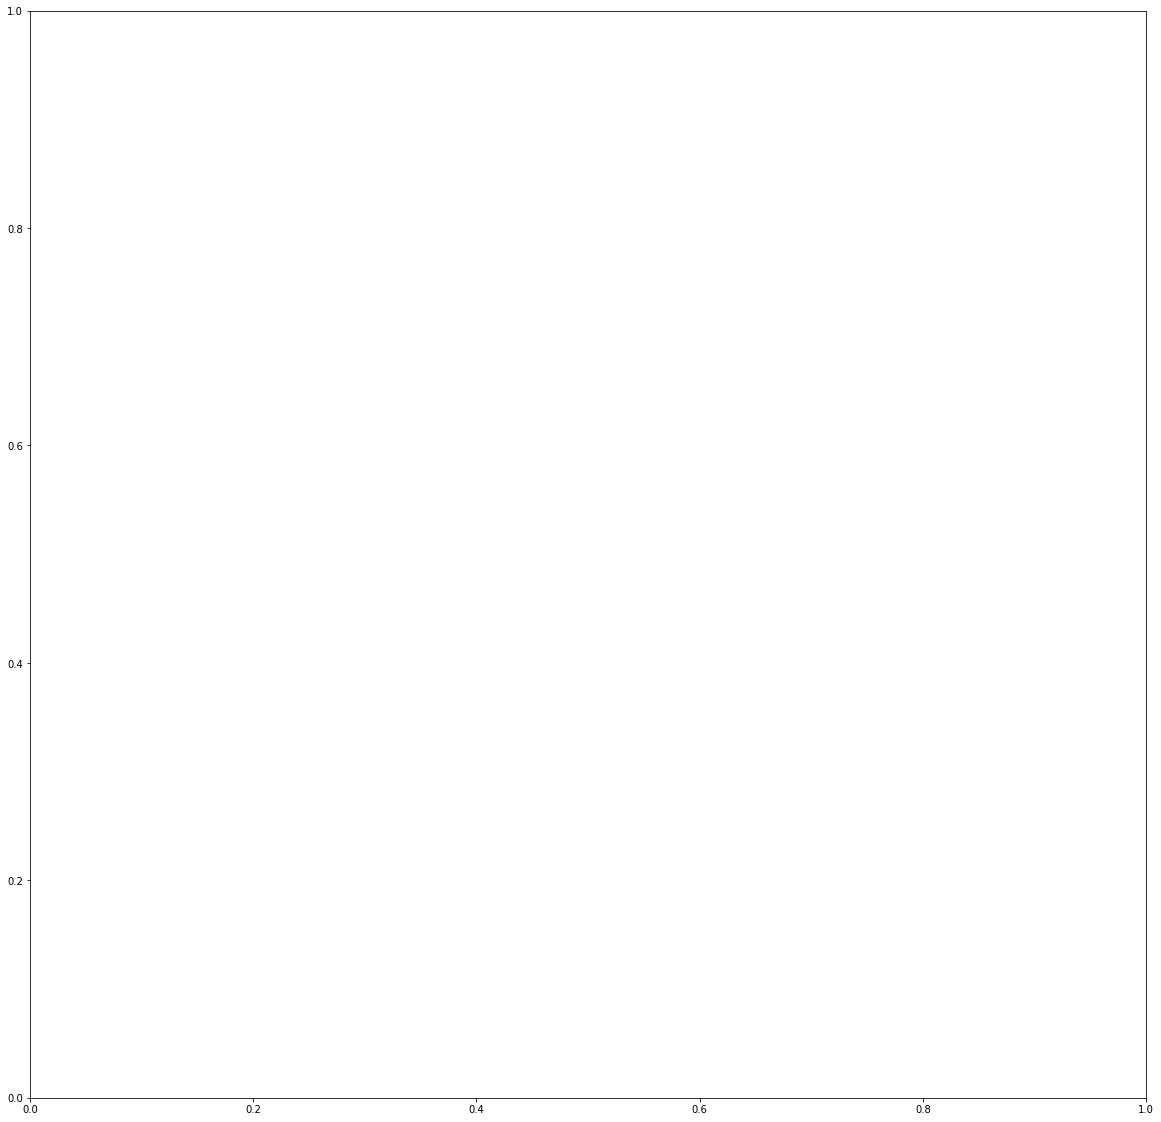

In [55]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(20, 20))

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = results_df[results_df.circuit == c1].groupby("model").value.agg({c1: "mean"})
        ys = results_df[results_df.circuit == c2].groupby("model").value.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s / %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax)
        
plt.title("Circuit--circuit correlations")

### Stability to modification

ValueError: min() arg is an empty sequence

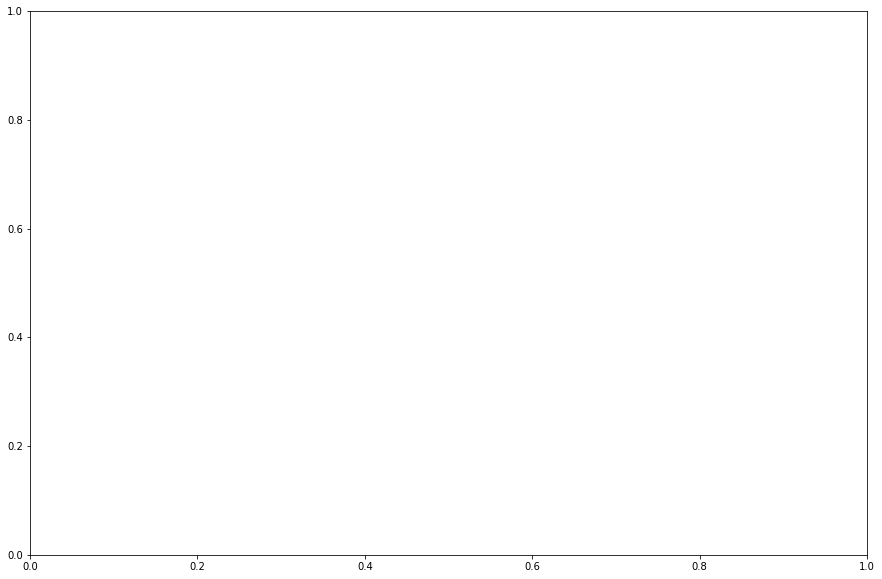

In [59]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="model", y="correct", hue="has_modifier")
plt.title("Stability to modification")

In [61]:
avg_mod_results = results_df_mod.groupby(["model", "test_suite_base", "has_modifier"]).correct.agg({"acc": "mean"}).sort_index()
avg_mod_diffs = avg_mod_results.xs(True, level="has_modifier") - avg_mod_results.xs(False, level="has_modifier")

plt.subplots(figsize=(15, 10))
sns.boxplot(data=avg_mod_diffs.reset_index(), x="model", y="correct")
plt.title("Change in accuracy due to modification")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


KeyError: True